In [18]:
import itertools
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

In [16]:
class NVMParser:
    """
    Parses a VisualSFM NVM file and can build a covisibility graph from its data.
    """

    def __init__(self):
        self.models = []
        self.camera_map = {} # Maps model_index -> {camera_index: filename}

    def parse(self, filepath: str) -> None:
        """
        Parses the NVM file and stores the structured data.

        Args:
            filepath (str): The path to the .nvm file.
        """
        print(f"Parsing NVM file: {filepath}...")
        self.models = []
        
        with open(filepath, 'r') as f:
            lines = f.readlines()

        # Basic validation and header check
        if not lines[0].strip().startswith("NVM_V3"):
            raise ValueError("File does not appear to be a valid NVM v3 file.")

        # The actual content starts after the header and a blank line
        # The line index `i` will be our cursor.
        i = 1 
        if "FixedK" in lines[i]: # Skip optional fixed calibration line
            i += 1
        
        while i < len(lines) and lines[i].strip() == "":
            i += 1 # Skip any blank lines after header

        model_idx = 0
        while True:
            # --- Start of a new model ---
            if i >= len(lines): break
            
            # 1. Parse number of cameras for the current model
            try:
                num_cameras = int(lines[i].strip())
            except (ValueError, IndexError):
                # This can happen if there are trailing empty lines
                print(f"Finished parsing models. Found trailing data or empty lines.")
                break
                
            # A model with 0 cameras signals the end of the models section
            if num_cameras == 0:
                print("End of models section reached.")
                break

            current_model = {"cameras": [], "points": []}
            current_camera_map = {}
            i += 1
            
            # 2. Parse camera list
            for cam_idx in range(num_cameras):
                line = lines[i].strip().split()
                filename = line[0]
                current_model["cameras"].append({"filename": filename, "data": line[1:]})
                current_camera_map[cam_idx] = filename
                i += 1
            
            self.camera_map[model_idx] = current_camera_map
            
            while i < len(lines) and lines[i].strip() == "":
                i += 1 # Skip blank lines

            # 3. Parse number of points for the current model
            if i >= len(lines): break
            num_points = int(lines[i].strip())
            i += 1

            # 4. Parse point list and their measurements
            for _ in range(num_points):
                line = lines[i].strip().split()
                # <XYZ> <RGB> <num_measurements> <List of Measurements>
                num_measurements = int(line[6])
                
                measurements_data = line[7:]
                measurements = []
                # Each measurement is 4 values: <Image index> <Feature Index> <xy>
                for j in range(0, len(measurements_data), 4):
                    measurement_chunk = measurements_data[j:j+4]
                    measurements.append({
                        "image_index": int(measurement_chunk[0]),
                        "feature_index": int(measurement_chunk[1]),
                        "xy": (float(measurement_chunk[2]), float(measurement_chunk[3]))
                    })
                
                current_model["points"].append({
                    "xyz": [float(c) for c in line[0:3]],
                    "rgb": [int(c) for c in line[3:6]],
                    "measurements": measurements
                })
                i += 1
                
            self.models.append(current_model)
            model_idx += 1

            while i < len(lines) and lines[i].strip() == "":
                i += 1 # Skip blank lines at the end of a model
        
        print(f"Successfully parsed {len(self.models)} model(s).")


    def build_covisibility_graph(self, model_index: int = 0) -> Dict[int, Dict[int, int]]:
        """
        Builds a covisibility graph for a specific parsed model.

        Args:
            model_index (int): The index of the model to use (default is the first one).

        Returns:
            Dict[int, Dict[int, int]]: The covisibility graph, where graph[i][j]
                                      is the number of shared points between camera i and j.
        """
        if not self.models or model_index >= len(self.models):
            raise IndexError(f"Model index {model_index} is out of bounds.")
            
        print(f"\nBuilding covisibility graph for Model {model_index}...")
        
        model = self.models[model_index]
        if not model["points"]:
            print("Warning: Model has no 3D points. Covisibility graph will be empty.")
            return {}
            
        # 1. Create a map from each 3D point to the list of cameras that see it.
        # The point's ID is its index in the list.
        point_to_images = defaultdict(list)
        for point_idx, point_data in enumerate(model["points"]):
            for measurement in point_data["measurements"]:
                point_to_images[point_idx].append(measurement["image_index"])

        # 2. Build the graph by finding shared observations.
        covisibility_graph = defaultdict(lambda: defaultdict(int))
        for point_idx, image_indices in point_to_images.items():
            # Get all unique pairs of images that see this point
            # For example, if images [1, 5, 8] see a point, this generates (1,5), (1,8), (5,8)
            for img_idx1, img_idx2 in itertools.combinations(sorted(list(set(image_indices))), 2):
                covisibility_graph[img_idx1][img_idx2] += 1
                covisibility_graph[img_idx2][img_idx1] += 1 # Make it symmetric

        print("Covisibility graph built successfully.")
        return dict(covisibility_graph)

    def print_covisibility_graph(self, graph: Dict[int, Dict[int, int]], model_index: int = 0):
        """Prints the graph in a human-readable format."""
        if not graph:
            print("Graph is empty.")
            return

        print(f"\n--- Covisibility Graph for Model {model_index} ---")
        
        cam_map = self.camera_map.get(model_index, {})

        # Sort for consistent output
        sorted_nodes = sorted(graph.keys())
        
        for cam_idx1 in sorted_nodes:
            cam_name1 = Path(cam_map.get(cam_idx1, f"Cam_{cam_idx1}")).name
            connections = []
            
            sorted_neighbors = sorted(graph[cam_idx1].keys())
            for cam_idx2 in sorted_neighbors:
                weight = graph[cam_idx1][cam_idx2]
                max_weight = max(weight, max_weight)
                cam_name2 = Path(cam_map.get(cam_idx2, f"Cam_{cam_idx2}")).name
                connections.append(f"{cam_name2} (w: {weight})")
                
            print(f"'{cam_name1}' is connected to: {', '.join(connections)}")
        print("--------------------------------------")

    def plot_edge_weight_histogram(self, graph: Dict, bins: int = 50):
        """Plots a histogram of the edge weights."""
        if not graph:
            print("Cannot plot histogram: graph is empty.")
            return
            
        # Extract unique edge weights (to avoid double counting)
        weights = []
        seen_pairs = set()
        for u, connections in graph.items():
            for v, weight in connections.items():
                if (u, v) not in seen_pairs and (v, u) not in seen_pairs:
                    weights.append(weight)
                    seen_pairs.add((u, v))

        plt.figure(figsize=(10, 6))
        sns.histplot(weights, bins=bins, kde=True)
        plt.title('Distribution of Covisibility Edge Weights (Shared 3D Points)')
        plt.xlabel('Number of Shared 3D Points (Edge Weight)')
        plt.ylabel('Number of Image Pairs (Frequency)')
        plt.grid(axis='y', alpha=0.75)
        plt.yscale('log') # Use a log scale for y-axis to see the long tail of hard pairs
        print("\nDisplaying edge weight histogram...")
        plt.show()

    def plot_adjacency_matrix(self, graph: Dict, model_index: int = 0):
        """Plots the graph as an adjacency matrix heatmap."""
        if not graph:
            print("Cannot plot adjacency matrix: graph is empty.")
            return
            
        cam_map = self.camera_map.get(model_index, {})
        node_labels = [Path(cam_map.get(i, f"Cam_{i}")).name for i in sorted(graph.keys())]
        
        # Convert graph to a pandas DataFrame, which is perfect for heatmaps
        df = pd.DataFrame(graph).fillna(0).astype(int)
        df = df.reindex(sorted(df.columns), axis=1) # Sort rows and columns
        df = df.reindex(sorted(df.index), axis=0)

        plt.figure(figsize=(12, 10))
        sns.heatmap(df, cmap="viridis", cbar_kws={'label': 'Number of Shared Points'})
        plt.title(f'Covisibility Adjacency Matrix for Model {model_index}')
        plt.xlabel('Camera Index')
        plt.ylabel('Camera Index')
        # Uncomment the next two lines if you have few cameras and want labels
        # plt.xticks(ticks=range(len(node_labels)), labels=node_labels, rotation=90)
        # plt.yticks(ticks=range(len(node_labels)), labels=node_labels, rotation=0)
        print("\nDisplaying adjacency matrix...")
        plt.show()

    def plot_network_graph(self, graph: Dict, model_index: int = 0, weight_threshold: int = 10):
        """Plots the graph as a node-link diagram."""
        if not graph:
            print("Cannot plot network graph: graph is empty.")
            return
            
        G = nx.Graph()
        cam_map = self.camera_map.get(model_index, {})
        
        for u, connections in graph.items():
            u_name = Path(cam_map.get(u, f"Cam_{u}")).name
            for v, weight in connections.items():
                if weight >= weight_threshold:
                    v_name = Path(cam_map.get(v, f"Cam_{v}")).name
                    G.add_edge(u_name, v_name, weight=weight)
                    
        if G.number_of_nodes() == 0:
            print(f"No edges found with weight >= {weight_threshold}. Cannot draw graph.")
            return

        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(G, k=0.5, iterations=50) # Position nodes using a spring layout
        
        # Draw nodes and edges
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
        
        # Draw labels for nodes
        # nx.draw_networkx_labels(G, pos, font_size=8) # This can be very cluttered
        
        plt.title(f'Covisibility Network Graph (Edges with weight >= {weight_threshold})')
        plt.axis('off')
        print(f"\nDisplaying network graph (for edges with weight >= {weight_threshold})...")
        plt.show()

Parsing NVM file: /mnt/d/code/Data/point_clouds/point_clouds_202/672e0a5b6f0b1500120c2cd8/metashape_out.nvm...
End of models section reached.
Successfully parsed 1 model(s).

Building covisibility graph for Model 0...
Covisibility graph built successfully.

Displaying edge weight histogram...


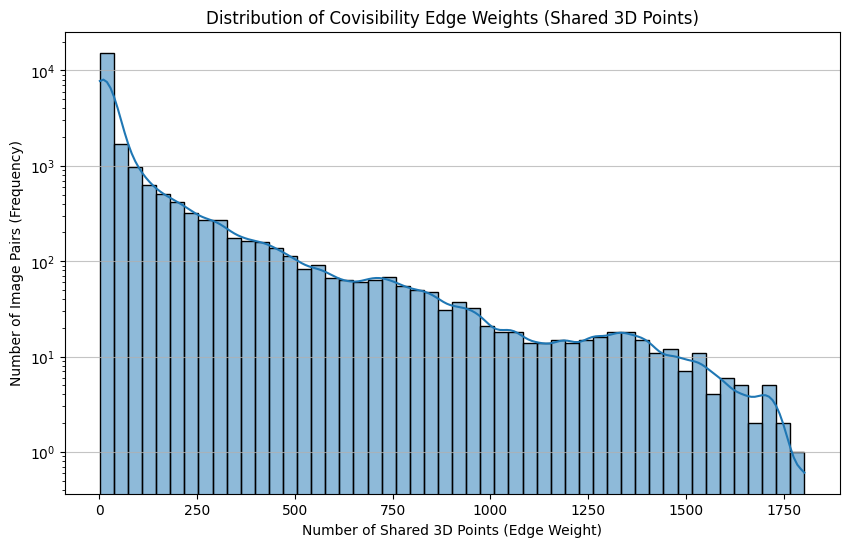


Displaying adjacency matrix...


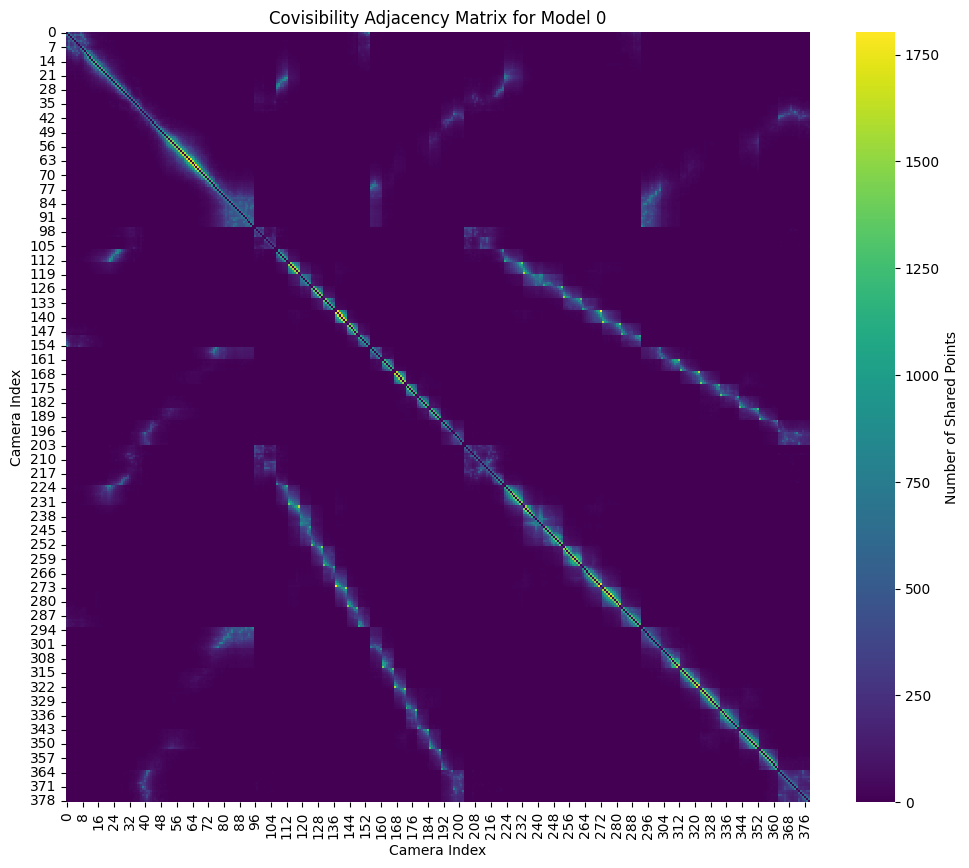


Displaying network graph (for edges with weight >= 250)...


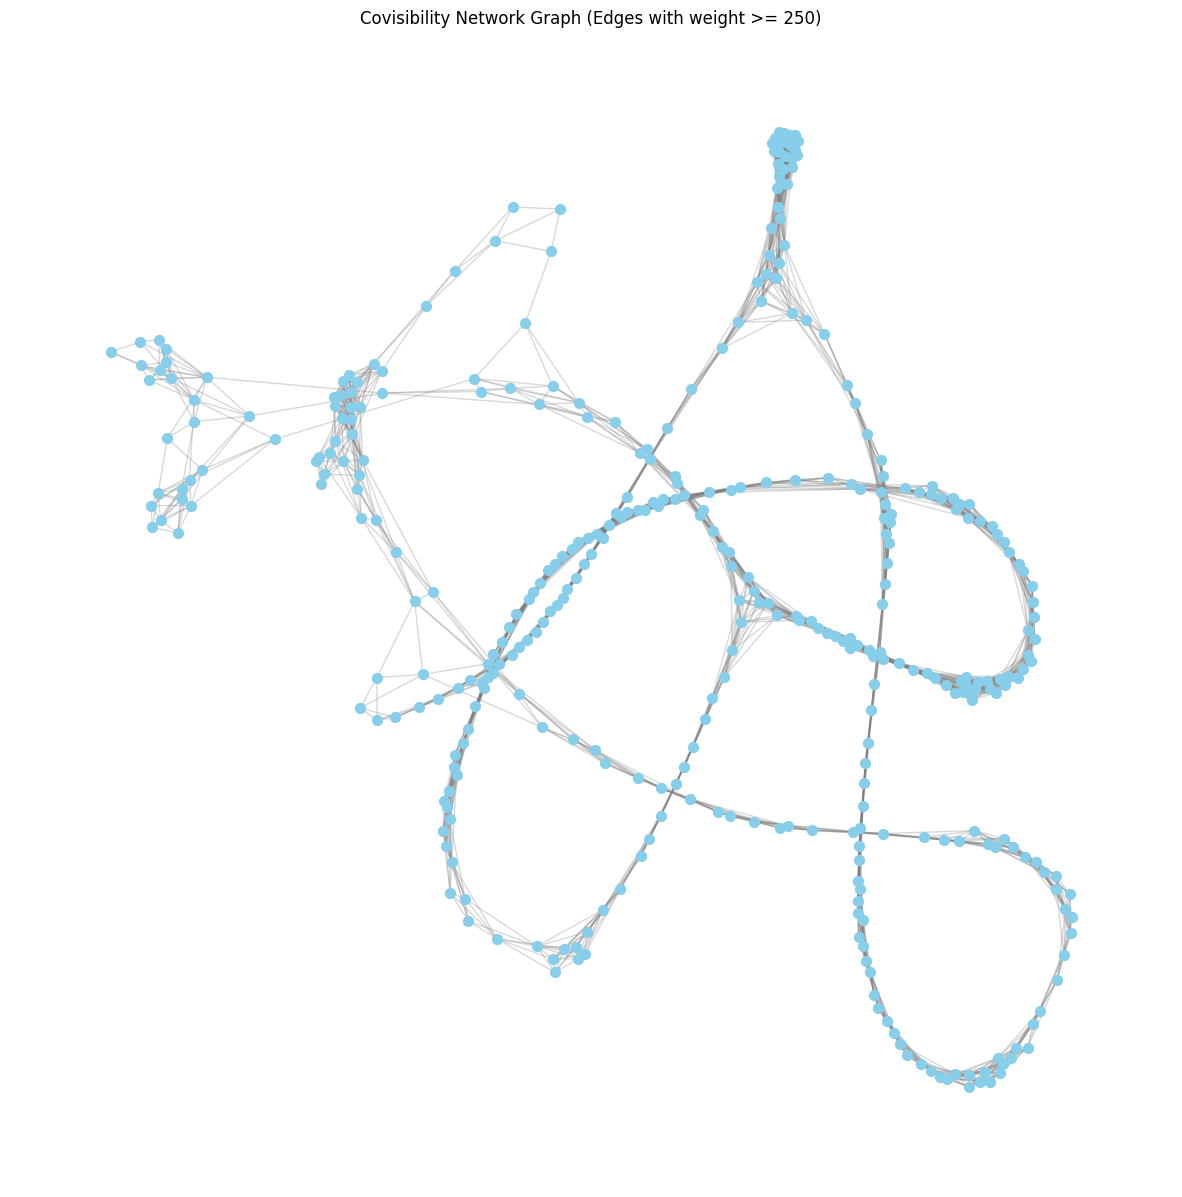

In [21]:
if __name__ == '__main__':
    # 1. NVM file to work with
    nvm_file_path = "/mnt/d/code/Data/point_clouds/point_clouds_202/672e0a5b6f0b1500120c2cd8/metashape_out.nvm"
    
    # 2. Initialize the parser and parse the file
    parser = NVMParser()
    try:
        parser.parse(nvm_file_path)
        
        # 3. Build the covisibility graph for the first model (index 0)
        # Check if any models were parsed successfully
        if parser.models:
            graph = parser.build_covisibility_graph(model_index=0)
            
            # 4. Print the graph for verification
            # parser.print_covisibility_graph(graph, model_index=0)
            parser.plot_edge_weight_histogram(graph)
            parser.plot_adjacency_matrix(graph)
            parser.plot_network_graph(graph, weight_threshold=250)
        else:
            print("No models found in the NVM file.")

    except (ValueError, IndexError) as e:
        print(f"An error occurred: {e}")